# sscan as 1D Flyer

<font color="red">NOTE</font>: This notebook is under construction!

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for [bluesky](http://nsls-ii.github.io/bluesky) data acquisition.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

Suggest the _noisy v m1_ scan, done as 1-D step scan with sscan record.  noisy is the swait record calculating a peak based on m1 position.

In [1]:
import os, pathlib, sys
sys.path.append(os.path.abspath(os.path.join(pathlib.Path.home(), "bluesky")))
from instrument.collection import *

I Wed-13:10:27 - ############################################################ startup
I Wed-13:10:27 - logging started
I Wed-13:10:27 - logging level = 10
I Wed-13:10:27 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Wed-13:10:27 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Wed-13:10:27 - #### Bluesky Framework ####
I Wed-13:10:27 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Wed-13:10:27 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Wed-13:10:28 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Wed-13:10:28 - using databroker catalog 'training'
I Wed-13:10:28 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Wed-13:10:28 - #### Devices ####
I Wed-13:10:28 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Wed-13:10:28 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Wed-13:10:31 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Wed-13:10:31 - /h

In [2]:
# add this notebook's name to the metadata

RE.md["notebook"] = "sscan_1d_flyer"

In [3]:
# define the IOC's prefix

ioc = "gp:"

## Bluesky step scan

We are told that the `noisy` signal will show a peak when `m1` is moved over the range `[-1 .. +1]`.  Use *bluesky* to show that peak.



Transient Scan ID: 281     Time: 2021-09-01 13:10:38
Persistent Unique Scan ID: '64319d7f-6547-44ba-bad8-ce618cae0f37'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 13:10:40.9 |   -1.10000 |    7.19976 |
|         2 | 13:10:41.3 |   -0.99000 |    8.38552 |
|         3 | 13:10:41.7 |   -0.88000 |   10.01920 |
|         4 | 13:10:42.1 |   -0.77000 |   11.65518 |
|         5 | 13:10:42.5 |   -0.66000 |   14.61347 |
|         6 | 13:10:42.9 |   -0.55000 |   17.96885 |
|         7 | 13:10:43.3 |   -0.44000 |   23.72455 |
|         8 | 13:10:43.7 |   -0.33000 |   31.10560 |
|         9 | 13:10:44.1 |   -0.22000 |   44.83714 |
|        10 | 13:10:44.5 |   -0.11000 |   66.88015 |
|        11 | 13:10:44.9 |    0.00000 |  109.62670 |
|        12 | 13:10:45.3 |    0.11000 |  224.90426 |
|        13 | 13:10:45.7 |    0.22000 |

('64319d7f-6547-44ba-bad8-ce618cae0f37',)

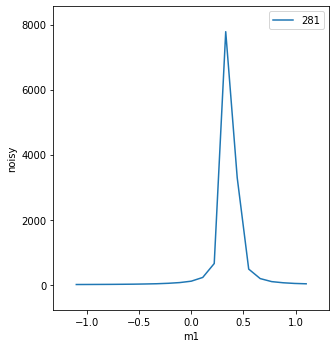

In [4]:
RE(bp.scan([noisy], m1, -1.1, 1.1, 21))

In [5]:
# from apstools.synApps import SaveData

# save_data = SaveData(f"{ioc}saveData_", name="save_data")

## sscan as Bluesky Flyer

In [6]:
from apstools.synApps import SscanRecord

class MySscanRecord(SscanRecord):
    
    def stage(self):
        super().stage()
        self.select_channels()
    
    def unstage(self):
        super().unstage()
        self.select_channels()

    def setup_staging_1D_step(self, start=-1.1, finish=1.1, npts=21, ddelay=0.01, pdelay=0):
        # configure sscan record for 1D step scan: noisy v. m1
        self.stage_sigs["number_points"] = npts
        self.stage_sigs["pasm"] = "PRIOR POS"
        self.stage_sigs["positioner_delay"] = pdelay
        self.stage_sigs["positioners.p1.setpoint_pv"] = m1.user_setpoint.pvname
        self.stage_sigs["positioners.p1.readback_pv"] = m1.user_readback.pvname
        self.stage_sigs["positioners.p1.start"] = start
        self.stage_sigs["positioners.p1.end"] = finish
        self.stage_sigs["detector_delay"] = ddelay
        self.stage_sigs["detectors.d01.input_pv"] = noisy.pvname

        # self.hints = {'fields': ['scan_positioners_p1_readback_value', 'scan_detectors_d01_current_value']}

scan = MySscanRecord(f"{ioc}scan1", name="scan")

# configure the sscan record for data collection:
scan.wait_for_connection()  # sscan records have _many_ channels and fields
scan.reset()  # clear out any previous configuration

scan.setup_staging_1D_step()
scan.select_channels()

In [ ]:
# TODO: if save data is to be used

    # # configure saveData for data collection into MDA files:
    # save_data.stage_sigs["file_system"] = "/tmp"
    # save_data.stage_sigs["subdirectory"] = "saveData"
    # save_data.stage_sigs["base_name"] = "sscan1_"
    # save_data.stage_sigs["next_scan_number"] = 1
    # save_data.stage_sigs["comment1"] = "testing"
    # save_data.stage_sigs["comment2"] = "configured and run from ophyd"

In [ ]:
# diagnostics
# -----------
# scan.stage()
# scan.unstage()
# RE(bp.count([scan]))
# scan.read()
# scan.stage??
# bp.fly??

In [8]:
from ophyd import DeviceStatus, Signal
from ophyd.flyers import FlyerInterface

In [23]:
class SscanFlyer_1D_StepSimple(FlyerInterface):
    
    sscan = None
    name = None
    
    def __init__(self, sscan, *args, name=None, **kwargs):
        self.sscan = sscan
        self._acquiring = False

        if name is None:
            raise ValueError("MUST provide `name` keyword argument.")
        self.name = name

        super().__init__(*args, **kwargs)

    def kickoff(self):
        # scan.reset()

        scan.setup_staging_1D_step()

        # set(), do not `yield`, in kickoff()
        self.sscan.execute_scan.set(1)  # start the sscan record
        self._acquiring = True

        status = DeviceStatus(self)
        status.set_finished()  # means that kickoff was successful
        return status

    def complete(self):
        """Wait for sscan to complete."""
        if not self._acquiring:
            raise RuntimeError("Not acquiring")

        st = DeviceStatus(self)
        cb_started = False

        def execute_scan_cb(value, timestamp, **kwargs):
            value = int(value)
            if cb_started and value == 0:
                scan.unstage()
                self._acquiring = False
                self.sscan.execute_scan.unsubscribe(execute_scan_cb)
                st.set_finished()

        self.sscan.execute_scan.subscribe(execute_scan_cb)
        # self.sscan.execute_scan.set(1)
        cb_started = True
        return st

    def describe_collect(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
        # Provide schema & meta-data from collect()
        return {
            "primary": {
                m1.name: {
                    "dims": [],
                    "dtype": "number",
                    "shape": [],
                    "source": "",
                },
                noisy.name: {
                    "dims": [],
                    "dtype": "number",
                    "shape": [],
                    "source": "",
                },
                # "time": {
                #     "dims": [],
                #     "dtype": "number",
                #     "shape": [],
                #     "source": "",
                # },
            },
        }

    def collect(self):
        """Retrieve all collected data (after complete())."""
        if self._acquiring:
            raise RuntimeError("Acquisition still in progress. Call complete() first.")
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
        # Retrieve data from the flyer as proto-events

        ts = time.time()
        p1 = [0, 1]
        d1 = [1, 0]
        yield {
            "data": {m1.name: p1, noisy.name: d1, },
            'timestamps': {m1.name: ts, noisy.name: ts, },
            'time': ts
        }

        # ts = time.time()
        # n = self.sscan.current_point.get()
        # p1 = scan.positioners.p1.array.get(use_monitor=False, as_numpy=True)[:n]
        # d1 = scan.detectors.d01.array.get(use_monitor=False, as_numpy=True)[:n]

        # yield {
        #     'data': {
        #         m1.name: p1,
        #         noisy.name: d1,
        #     },
        #     'timestamps': {
        #         m1.name: ts,
        #         noisy.name: ts,
        #     },
        #     'time': ts
        # }

In [24]:
scan_flyer = SscanFlyer_1D_StepSimple(scan, name="scan_flyer")



Transient Scan ID: 285     Time: 2021-09-01 13:28:00
Persistent Unique Scan ID: '32a0468c-52ab-403b-bad6-df08cd091b02'
New stream: 'baseline'


Subscription value callback exception (EpicsSignal(read_pv='gp:scan1.EXSC', name='scan_execute_scan', parent='scan', value=0, timestamp=1630520880.539632, auto_monitor=True, string=False, write_pv='gp:scan1.EXSC', limits=False, put_complete=False))
Traceback (most recent call last):
  File "/home/prjemian/.local/lib/python3.8/site-packages/ophyd/ophydobj.py", line 462, in inner
    cb(*args, **kwargs)
  File "<ipython-input-15-8e1ded5f6164>", line 43, in execute_scan_cb
    st.set_finished()
  File "/home/prjemian/.local/lib/python3.8/site-packages/ophyd/status.py", line 319, in set_finished
    raise InvalidState(
ophyd.utils.errors.InvalidState: Either set_finished() or set_exception() has already been called on DeviceStatus(device=scan_flyer, done=True, success=True)
Subscription value callback exception (EpicsSignal(read_pv='gp:scan1.EXSC', name='scan_execute_scan', parent='scan', value=0, timestamp=1630520880.539632, auto_monitor=True, string=False, write_pv='gp:scan1.EXSC', limit

New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+


/home/prjemian/.local/lib/python3.8/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+------------+------------+
generator fly ['32a0468c'] (scan num: 285)
LivePlot did not get any data that corresponds to the x axis. time
LivePlot did not get any data that corresponds to the y axis. m1
LivePlot did not get any data that corresponds to the x axis. time
LivePlot did not get any data that corresponds to the y axis. noisy


('32a0468c-52ab-403b-bad6-df08cd091b02',)

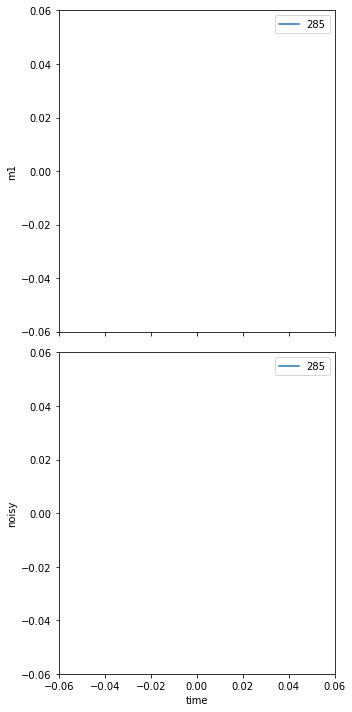

In [25]:
RE(bp.fly([scan_flyer]))

## MockFlyer with motor and pseudo-detector

ophyd's *MockFlyer* example : https://github.com/NSLS-II/ophyd/blob/master/ophyd/sim.py#L546

In [ ]:
import asyncio
from collections import deque
from collections import OrderedDict
from ophyd import DeviceStatus
import time

class MockFlyer:
    """
    Class for mocking a flyscan API implemented with stepper motors.
    """

    def __init__(self, name, detector, motor, start, stop, num, loop=None):
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = np.linspace(start, stop, num)
        self._data = deque()
        self._completion_status = None
        if loop is None:
            loop = asyncio.get_event_loop()
        self.loop = loop

    def __setstate__(self, val):
        name, detector, motor, steps = val
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = steps
        self._completion_status = None
        self.loop = asyncio.get_event_loop()

    def __getstate__(self):
        return (self.name, self._detector, self._mot, self._steps)

    def read_configuration(self):
        return OrderedDict()

    def describe_configuration(self):
        return OrderedDict()

    def describe_collect(self):
        dd = dict()
        dd.update(self._mot.describe())
        dd.update(self._detector.describe())
        return {'stream_name': dd}

    def complete(self):
        if self._completion_status is None:
            raise RuntimeError("No collection in progress")
        return self._completion_status

    def kickoff(self):
        if self._completion_status is not None:
            raise RuntimeError("Already kicked off.")
        self._data = deque()

        self._future = self.loop.run_in_executor(None, self._scan)
        st = DeviceStatus(device=self)
        self._completion_status = st
        self._future.add_done_callback(lambda x: st._finished())
        return st

    def collect(self):
        if self._completion_status is None or not self._completion_status.done:
            raise RuntimeError("No reading until done!")
        self._completion_status = None

        yield from self._data

    def _scan(self):
        "This will be run on a separate thread, started in self.kickoff()"
        time.sleep(.1)
        for p in self._steps:
            stat = self._mot.set(p)
            while True:
                if stat.done:
                    break
                time.sleep(0.01)
            stat = self._detector.trigger()
            while True:
                if stat.done:
                    break
                time.sleep(0.01)

            event = dict()
            event['time'] = time.time()
            event['data'] = dict()
            event['timestamps'] = dict()
            for r in [self._mot, self._detector]:
                d = r.read()
                for k, v in d.items():
                    event['data'][k] = v['value']
                    event['timestamps'][k] = v['timestamp']
            self._data.append(event)

    def stop(self, *, success=False):
        pass


In [ ]:
mflyer = MockFlyer('mflyer', noisy, m1, -1.1, 1.2, 29)

In [ ]:
RE(bp.scan([noisy], m1, -1.1, 1.1, 11))

In [ ]:
run = cat[-1]
run.primary.read()